# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 KB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 29.2 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 2.8 MB/s eta 0:00:00a 0:00:01
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 1.0 MB/s eta 0:00:00ta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [9]:
client = MongoClient(mongod_connect)
db = client.demo # use or create a database named demo
tweet_collection = db.lab9 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [10]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [11]:
track = ['covid19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [14]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [15]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [29]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [33]:
search_results = rest_api.search.tweets( count=count,q=q) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Tue Nov 29 01:40:49 +0000 2022'
'Tue Nov 29 01:40:49 +0000 2022'
'Tue Nov 29 01:40:48 +0000 2022'
'Tue Nov 29 01:40:47 +0000 2022'
'Tue Nov 29 01:40:43 +0000 2022'
'Tue Nov 29 01:40:42 +0000 2022'
'Tue Nov 29 01:40:38 +0000 2022'
'Tue Nov 29 01:40:37 +0000 2022'
'Tue Nov 29 01:40:36 +0000 2022'
'Tue Nov 29 01:40:32 +0000 2022'
'Tue Nov 29 01:40:31 +0000 2022'
'Tue Nov 29 01:40:31 +0000 2022'
'Tue Nov 29 01:40:30 +0000 2022'
'Tue Nov 29 01:40:28 +0000 2022'
'Tue Nov 29 01:40:27 +0000 2022'
'Tue Nov 29 01:40:26 +0000 2022'
'Tue Nov 29 01:40:25 +0000 2022'
'Tue Nov 29 01:40:24 +0000 2022'
'Tue Nov 29 01:40:22 +0000 2022'
'Tue Nov 29 01:40:20 +0000 2022'
'Tue Nov 29 01:40:17 +0000 2022'
'Tue Nov 29 01:40:13 +0000 2022'
'Tue Nov 29 01:40:12 +0000 2022'
'Tue Nov 29 01:40:09 +0000 2022'
'Tue Nov 29 01:40:09 +0000 2022'
'Tue Nov 29 01:40:08 +0000 2022'
'Tue Nov 29 01:40:06 +0000 2022'
'Tue Nov 29 01:40:05 +0000 2022'
'Tue Nov 29 01:40:05 +0000 2022'
'Tue Nov 29 01:40:04 +0000 2022'
'Tue Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [35]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                         max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sun Nov 20 15:59:16 +0000 2022'
'Sun Nov 20 15:59:14 +0000 2022'
'Sun Nov 20 15:59:13 +0000 2022'
'Sun Nov 20 15:59:13 +0000 2022'
'Sun Nov 20 15:59:09 +0000 2022'
'Sun Nov 20 15:59:09 +0000 2022'
'Sun Nov 20 15:59:08 +0000 2022'
'Sun Nov 20 15:59:07 +0000 2022'
'Sun Nov 20 15:59:04 +0000 2022'
'Sun Nov 20 15:59:02 +0000 2022'
'Sun Nov 20 15:59:01 +0000 2022'
'Sun Nov 20 15:59:00 +0000 2022'
'Sun Nov 20 15:59:00 +0000 2022'
'Sun Nov 20 15:58:59 +0000 2022'
'Sun Nov 20 15:58:58 +0000 2022'
'Sun Nov 20 15:58:54 +0000 2022'
'Sun Nov 20 15:58:53 +0000 2022'
'Sun Nov 20 15:58:52 +0000 2022'
'Sun Nov 20 15:58:52 +0000 2022'
'Sun Nov 20 15:58:51 +0000 2022'
'Sun Nov 20 15:58:49 +0000 2022'
'Sun Nov 20 15:58:47 +0000 2022'
'Sun Nov 20 15:58:47 +0000 2022'
'Sun Nov 20 15:58:46 +0000 2022'
'Sun Nov 20 15:58:46 +0000 2022'
'Sun Nov 20 15:58:41 +0000 2022'
'Sun Nov 20 15:58:41 +0000 2022'
'Sun Nov 20 15:58:38 +0000 2022'
'Sun Nov 20 15:58:36 +0000 2022'
'Sun Nov 20 15:58:35 +0000 2022'
'Sun Nov 2

'Sun Nov 20 15:49:51 +0000 2022'
'Sun Nov 20 15:49:51 +0000 2022'
'Sun Nov 20 15:49:44 +0000 2022'
'Sun Nov 20 15:49:38 +0000 2022'
'Sun Nov 20 15:49:37 +0000 2022'
'Sun Nov 20 15:49:32 +0000 2022'
'Sun Nov 20 15:49:30 +0000 2022'
'Sun Nov 20 15:49:23 +0000 2022'
'Sun Nov 20 15:49:20 +0000 2022'
'Sun Nov 20 15:49:19 +0000 2022'
'Sun Nov 20 15:49:16 +0000 2022'
'Sun Nov 20 15:49:16 +0000 2022'
'Sun Nov 20 15:49:16 +0000 2022'
'Sun Nov 20 15:49:13 +0000 2022'
'Sun Nov 20 15:49:13 +0000 2022'
'Sun Nov 20 15:49:08 +0000 2022'
'Sun Nov 20 15:49:04 +0000 2022'
'Sun Nov 20 15:49:04 +0000 2022'
'Sun Nov 20 15:49:02 +0000 2022'
'Sun Nov 20 15:49:00 +0000 2022'
'Sun Nov 20 15:48:59 +0000 2022'
'Sun Nov 20 15:48:56 +0000 2022'
'Sun Nov 20 15:48:53 +0000 2022'
'Sun Nov 20 15:48:47 +0000 2022'
'Sun Nov 20 15:48:47 +0000 2022'
'Sun Nov 20 15:48:46 +0000 2022'
'Sun Nov 20 15:48:46 +0000 2022'
'Sun Nov 20 15:48:46 +0000 2022'
'Sun Nov 20 15:48:45 +0000 2022'
'Sun Nov 20 15:48:44 +0000 2022'
'Sun Nov 2

'Sun Nov 20 15:40:03 +0000 2022'
'Sun Nov 20 15:40:00 +0000 2022'
'Sun Nov 20 15:39:56 +0000 2022'
'Sun Nov 20 15:39:55 +0000 2022'
'Sun Nov 20 15:39:48 +0000 2022'
'Sun Nov 20 15:39:43 +0000 2022'
'Sun Nov 20 15:39:36 +0000 2022'
'Sun Nov 20 15:39:35 +0000 2022'
'Sun Nov 20 15:39:33 +0000 2022'
'Sun Nov 20 15:39:32 +0000 2022'
'Sun Nov 20 15:39:31 +0000 2022'
'Sun Nov 20 15:39:30 +0000 2022'
'Sun Nov 20 15:39:28 +0000 2022'
'Sun Nov 20 15:39:27 +0000 2022'
'Sun Nov 20 15:39:25 +0000 2022'
'Sun Nov 20 15:39:17 +0000 2022'
'Sun Nov 20 15:39:16 +0000 2022'
'Sun Nov 20 15:39:14 +0000 2022'
'Sun Nov 20 15:39:03 +0000 2022'
'Sun Nov 20 15:39:01 +0000 2022'
'Sun Nov 20 15:38:59 +0000 2022'
'Sun Nov 20 15:38:58 +0000 2022'
'Sun Nov 20 15:38:58 +0000 2022'
'Sun Nov 20 15:38:54 +0000 2022'
'Sun Nov 20 15:38:53 +0000 2022'
'Sun Nov 20 15:38:51 +0000 2022'
'Sun Nov 20 15:38:50 +0000 2022'
'Sun Nov 20 15:38:46 +0000 2022'
'Sun Nov 20 15:38:46 +0000 2022'
'Sun Nov 20 15:38:45 +0000 2022'
'Sun Nov 2

'Sun Nov 20 15:28:36 +0000 2022'
'Sun Nov 20 15:28:34 +0000 2022'
'Sun Nov 20 15:28:31 +0000 2022'
'Sun Nov 20 15:28:31 +0000 2022'
'Sun Nov 20 15:28:25 +0000 2022'
'Sun Nov 20 15:28:23 +0000 2022'
'Sun Nov 20 15:28:23 +0000 2022'
'Sun Nov 20 15:28:23 +0000 2022'
'Sun Nov 20 15:28:21 +0000 2022'
'Sun Nov 20 15:28:19 +0000 2022'
'Sun Nov 20 15:28:18 +0000 2022'
'Sun Nov 20 15:28:18 +0000 2022'
'Sun Nov 20 15:28:13 +0000 2022'
'Sun Nov 20 15:28:12 +0000 2022'
'Sun Nov 20 15:28:11 +0000 2022'
'Sun Nov 20 15:28:10 +0000 2022'
'Sun Nov 20 15:28:08 +0000 2022'
'Sun Nov 20 15:28:04 +0000 2022'
'Sun Nov 20 15:28:01 +0000 2022'
'Sun Nov 20 15:27:54 +0000 2022'
'Sun Nov 20 15:27:47 +0000 2022'
'Sun Nov 20 15:27:46 +0000 2022'
'Sun Nov 20 15:27:37 +0000 2022'
'Sun Nov 20 15:27:37 +0000 2022'
'Sun Nov 20 15:27:35 +0000 2022'
'Sun Nov 20 15:27:34 +0000 2022'
'Sun Nov 20 15:27:33 +0000 2022'
'Sun Nov 20 15:27:26 +0000 2022'
'Sun Nov 20 15:27:21 +0000 2022'
'Sun Nov 20 15:27:20 +0000 2022'
'Sun Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [36]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1525
1226


Create a text index and print the Tweets containing specific keywords. 

In [37]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [43]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pprint to display tweets

In [44]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Wayne Beech
text: @TravisZarelli @FLbeachrealtor @Victorshi2020 We need an Election Day; not an election month!
----
name: Chris Go HOGS!! "@RazorbackMBB is No. 9"
text: @hodgetwins And Maricopa elections are run by Republicans.  4 of the 5 election board members in that county are republicans.
----
name: Antoinette Grajeda
text: The Arkansas Board of Election Commissioners has agreed to open an investigation into the Phillips County Election… https://t.co/oAfop6M7SK
----
name: Bro Charlie
text: The government of Brazil stole one election, and the people took to the streets. Our government stole two elections… https://t.co/MAVusA5BD6
----
name: GP
text: @Rasmussen_Poll This election is done. It’s obvious that neither side of the aisle in Arizona wants legit elections… https://t.co/KRZPoabnS4
----
name: 👩🏻‍🦰 Ariel ◻️
text: @FloridadadD I think he’s going to say something like, “I’ve already shown that I can win an election, two election… https://t.co/Ejw0qHmP8u
----
name: Kel

In [45]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "election"}}) # return tweets contain vote

Use pandas to display tweets

In [46]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,6385623ee99cd2204c4ffe5a,Mon Nov 28 04:21:39 +0000 2022,1597083275125993473,1597083275125993473,@TravisZarelli @FLbeachrealtor @Victorshi2020 ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.597076e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,63856249e99cd2204c4ffed9,Thu Nov 24 18:58:49 +0000 2022,1595854470331727872,1595854470331727872,@hodgetwins And Maricopa elections are run by ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.595852e+18,...,0,3,False,False,en,NaN,NaN,NaN,NaN,NaN
2,6385623ee99cd2204c4ffe41,Mon Nov 28 17:49:06 +0000 2022,1597286476647403520,1597286476647403520,The Arkansas Board of Election Commissioners h...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,3,False,False,en,False,NaN,NaN,NaN,NaN
3,6385624ae99cd2204c4fff0e,Wed Nov 23 16:16:12 +0000 2022,1595451156612124672,1595451156612124672,"The government of Brazil stole one election, a...",True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,4,False,False,en,NaN,NaN,NaN,NaN,NaN
4,6385623ee99cd2204c4ffe66,Sun Nov 27 21:19:57 +0000 2022,1596977147901460480,1596977147901460480,@Rasmussen_Poll This election is done. It’s ob...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.596976e+18,...,0,11,False,False,en,NaN,NaN,NaN,NaN,NaN
5,6385623fe99cd2204c4ffe70,Sun Nov 27 17:23:40 +0000 2022,1596917685769863169,1596917685769863169,@FloridadadD I think he’s going to say somethi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.596917e+18,...,0,1,False,False,en,NaN,NaN,NaN,NaN,NaN
6,6385624de99cd2204c4fffb6,Sun Nov 20 20:03:33 +0000 2022,1594421205766922240,1594421205766922240,The Dem &amp;social media sites started a coup...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
7,6385623fe99cd2204c4ffe6d,Sun Nov 27 17:55:44 +0000 2022,1596925756910997504,1596925756910997504,@TomFitton The 2020 election,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.596681e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
8,6385623ee99cd2204c4ffe5c,Mon Nov 28 03:16:22 +0000 2022,1597066846577995776,1597066846577995776,@The_FJC New election.,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.596977e+18,...,0,1,False,False,en,NaN,NaN,NaN,NaN,NaN
9,6385624ee99cd2204c4fffcc,Sun Nov 20 12:50:51 +0000 2022,1594312313213001731,1594312313213001731,@KariLake You still lost the election!,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.594140e+18,...,0,2,False,False,en,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

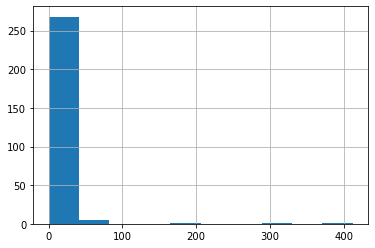

In [47]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count